In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

import json
import numpy as np

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .option("inferSchema", "true") \
        .option("nullValue", "-")\
        .load(folderpath)
        
    data_frame = rename_columns(
        data_frame,
        [
            ("cardNum18", "cardNum"),
            ("cardNum19", "userGender"),
        ]
    )
    
    date = "-".join(folderpath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.date_sub(F.col("date"),1))

    return data_frame

def read_buste_data_v3(sqlContext, filepath):
    data_frame = sqlContext.read.csv(filepath, header=True,
                                     inferSchema=True,nullValue="-")
    
    date = "-".join(filepath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.unix_timestamp(F.date_sub(F.col("date"),1),'yyyy-MM-dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

### Read BUSTE result Data

In [3]:
sc = SparkContext.getOrCreate()
sqlContext = pyspark.SQLContext(sc)

In [4]:
exp_data_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/buste-v3a/'

In [5]:
buste_data = read_hdfs_folder(sqlContext, exp_data_folder_path + '/bulma-output/2017_05_11_veiculos.csv/')

In [6]:
printdf(buste_data)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,901,8,2899,6191404,-25.426912,-49.279239,863.953,MC304,None,-25.426885,...,3.177324,12:00:18,26722,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
1,901,8,2899,6191416,-25.425207,-49.279476,1069.936,MC304,None,-25.425250,...,6.342949,12:01:01,26638,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
2,901,8,2899,6191429,-25.423221,-49.280815,1381.224,MC304,None,-25.423193,...,10.632870,12:02:36,26637,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
3,901,8,2899,6191441,-25.422463,-49.284100,1723.696,MC304,None,NaN,...,NaN,12:03:51,32794,BETWEEN,None,None,None,NaN,None,2017-05-10
4,901,8,2899,6191457,-25.422289,-49.288080,2133.278,MC304,None,-25.422263,...,3.002426,12:04:50,32795,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
5,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,12/07/98,12:05:42,STA. FELICIDADE,3694801.0,F,2017-05-10
6,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,29/08/66,12:06:25,STA. FELICIDADE,2265034.0,F,2017-05-10
7,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,02/05/98,12:06:19,STA. FELICIDADE,3736192.0,M,2017-05-10
8,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,06/07/02,12:09:35,STA. FELICIDADE,2444646.0,M,2017-05-10
9,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,02/10/03,12:09:21,STA. FELICIDADE,2444654.0,M,2017-05-10


In [7]:
buste_data.printSchema()

root
 |-- route: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)



In [8]:
total_records = buste_data.count()
print total_records

637707


In [9]:
total_passengers = buste_data.select('cardNum').distinct().count()
print total_passengers

107689


### Cleaning Buste Data

In [13]:
clean_buste_data = buste_data.na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp","shapeLon","shapeLat"])

In [14]:
total_filtered_boardings = clean_buste_data.count()
print total_filtered_boardings, "(", 100*(total_filtered_boardings/float(total_records)), "%)"
printdf(clean_buste_data)

616733 ( 96.7110287326 %)


,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,901,8,2899,6191404,-25.426912,-49.279239,863.953,MC304,None,-25.426885,...,3.177324,12:00:18,26722,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
1,901,8,2899,6191416,-25.425207,-49.279476,1069.936,MC304,None,-25.425250,...,6.342949,12:01:01,26638,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
2,901,8,2899,6191429,-25.423221,-49.280815,1381.224,MC304,None,-25.423193,...,10.632870,12:02:36,26637,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
3,901,8,2899,6191441,-25.422463,-49.284100,1723.696,MC304,None,NaN,...,NaN,12:03:51,32794,BETWEEN,None,None,None,NaN,None,2017-05-10
4,901,8,2899,6191457,-25.422289,-49.288080,2133.278,MC304,None,-25.422263,...,3.002426,12:04:50,32795,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
5,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,12/07/98,12:05:42,STA. FELICIDADE,3694801.0,F,2017-05-10
6,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,29/08/66,12:06:25,STA. FELICIDADE,2265034.0,F,2017-05-10
7,901,8,2899,6191462,-25.422660,-49.289950,2325.793,MC304,None,-25.422646,...,10.770773,12:05:29,32796,NO_PROBLEM,02/05/98,12:06:19,STA. FELICIDADE,3736192.0,M,2017-05-10
8,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,06/07/02,12:09:35,STA. FELICIDADE,2444646.0,M,2017-05-10
9,901,8,2899,6191478,-25.421165,-49.292240,2642.556,MC304,None,-25.421143,...,6.142177,12:08:29,33681,NO_PROBLEM,02/10/03,12:09:21,STA. FELICIDADE,2444654.0,M,2017-05-10


### Preparing Boarding Data for Analysis

In [15]:
filtered_boardings = clean_buste_data.na.drop(subset=['cardNum','cardTimestamp']) \
                            .dropDuplicates(['cardNum','date','cardTimestamp'])

In [17]:
non_duplicated_boardings = filtered_boardings.count()
print non_duplicated_boardings, "(", 100*(non_duplicated_boardings/float(total_records)), "%)"
printdf(filtered_boardings)

 140031 ( 21.9585169992 %)


,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,547,15,4125,6165607,-25.541827,-49.264612,4097.772,GA142,None,-25.541680,...,31.689760,05:53:33,31271,NO_PROBLEM,22/04/63,05:54:23,V. SÃO PEDRO,431802,F,2017-05-10
1,828,1,2941,4249004,-25.460141,-49.340811,9660.000,LA001,None,-25.460058,...,9.355352,06:06:58,34257,NO_PROBLEM,28/05/63,06:07:54,C.COMP/C.RASO,433069,F,2017-05-10
2,777,11,2195,4299895,-25.442293,-49.269757,1126.717,JC006,None,-25.442241,...,7.728910,17:59:39,32903,NO_PROBLEM,03/02/93,18:00:33,V. VELHA,444810,F,2017-05-10
3,658,1,2115,6642358,-25.491613,-49.349015,2871.251,JA027,None,-25.491595,...,3.681068,06:18:32,35720,NO_PROBLEM,28/07/71,06:19:29,C.RASO/CAIUÁ,624028,M,2017-05-10
4,332,26,1864,5605729,-25.474949,-49.194635,4197.070,DA300,None,-25.474938,...,7.856321,15:16:37,32457,NO_PROBLEM,04/04/68,15:17:35,ACRÓPOLE,742198,F,2017-05-10
5,628,2,2055,6035022,-25.544264,-49.315882,11215.314,HA016,None,-25.544026,...,40.477060,07:59:07,35163,NO_PROBLEM,06/03/89,07:59:30,CARBOMAFRA,768474,F,2017-05-10
6,050,2,1719,5305264,-25.476441,-49.321794,909.737,DR103,None,NaN,...,NaN,08:57:43,31638,BETWEEN,01/06/77,08:57:55,INTERBAIRROS V,810569,F,2017-05-10
7,812,4,2211,4166911,-25.418983,-49.351245,2163.377,BA022,None,NaN,...,NaN,07:19:16,30336,BETWEEN,04/02/81,07:19:29,MONTANA,811762,F,2017-05-10
8,614,4,2030,5808518,-25.451123,-49.252929,9972.134,GR405,None,-25.451110,...,4.154369,12:56:27,31749,NO_PROBLEM,20/09/66,12:57:31,FAZENDINHA/PUC,829222,M,2017-05-10
9,561,15,2005,6405261,-25.462226,-49.262185,3596.773,EC002,None,-25.462290,...,11.532125,18:59:00,31986,NO_PROBLEM,24/04/57,18:59:08,GUILHERMINA,846408,F,2017-05-10


### Removing single-trip users records

In [18]:
boarding_count = filtered_boardings.groupby('cardNum').count()

In [19]:
#Filtering only users with more than one ride per day
multiple_boardings = boarding_count.filter(F.col('count') > 1)

In [21]:
total_passengers = filtered_boardings.select('cardNum').distinct().count()
print "Total #Passengers:", total_passengers

Total #Passengers: 107688


In [22]:
passengers_mult_boardings = multiple_boardings.count()
prop_mult_boardings = 100*(passengers_mult_boardings)/total_passengers
print "Passengers with Multiple Boardings:", passengers_mult_boardings, "(", prop_mult_boardings, "%)" 
multiple_boardings.show()

Passengers with Multiple Boardings: 26687 ( 24 %)
+-------+-----+
|cardNum|count|
+-------+-----+
|3522158|    2|
|2298968|    2|
|3790541|    2|
|3821560|    2|
|3754400|    2|
|3639748|    4|
|3553903|    2|
|3337195|    3|
|2684240|    2|
|2921321|    2|
|1842089|    2|
|3513107|    2|
|1065595|    2|
|3599737|    2|
|3513400|    2|
|2570449|    2|
|3780899|    2|
| 814837|    2|
|2356476|    3|
|2279865|    2|
+-------+-----+
only showing top 20 rows



In [23]:
multiple_boardings = multiple_boardings.select(F.col("cardNum").alias("cardNum1"),
                                                 F.col("count").alias("count1"))

In [24]:
clean_boardings = filtered_boardings.join(multiple_boardings, filtered_boardings.cardNum == multiple_boardings.cardNum1, 'leftsemi')

In [25]:
clean_boardings.count()

59030

In [26]:
printdf(clean_boardings)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,777,11,2195,4299895,-25.442293,-49.269757,1126.717,JC006,None,-25.442241,...,7.728910,17:59:39,32903,NO_PROBLEM,03/02/93,18:00:33,V. VELHA,444810,F,2017-05-10
1,658,1,2115,6642358,-25.491613,-49.349015,2871.251,JA027,None,-25.491595,...,3.681068,06:18:32,35720,NO_PROBLEM,28/07/71,06:19:29,C.RASO/CAIUÁ,624028,M,2017-05-10
2,050,2,1719,5305264,-25.476441,-49.321794,909.737,DR103,None,NaN,...,NaN,08:57:43,31638,BETWEEN,01/06/77,08:57:55,INTERBAIRROS V,810569,F,2017-05-10
3,614,4,2030,5808518,-25.451123,-49.252929,9972.134,GR405,None,-25.451110,...,4.154369,12:56:27,31749,NO_PROBLEM,20/09/66,12:57:31,FAZENDINHA/PUC,829222,M,2017-05-10
4,684,2,2148,6636357,-25.592501,-49.332138,1905.881,HR408,None,-25.592538,...,5.097825,07:11:26,39373,NO_PROBLEM,06/08/73,07:11:39,RIO BONITO,927336,F,2017-05-10
5,020,4,3259,6011355,-25.486591,-49.255923,15948.485,BB613,None,-25.486621,...,25.342314,12:51:26,32712,NO_PROBLEM,31/12/83,12:51:53,INTERBAIRR II H,993266,M,2017-05-10
6,040,1,1717,3366719,-25.432890,-49.352078,5740.658,JB499,None,-25.433115,...,26.680422,06:41:13,33973,NO_PROBLEM,02/11/63,06:41:17,OP. CONTIGENCIA,1074995,F,2017-05-10
7,211,10,1776,6633474,-25.408844,-49.237411,3637.558,BA277,None,NaN,...,NaN,12:00:01,29757,BETWEEN,21/08/89,12:00:09,COLINA VERDE,1338099,F,2017-05-10
8,338,1,1871,5884653,-25.483813,-49.223565,9008.924,EA001,None,-25.483675,...,15.946461,06:22:02,32574,NO_PROBLEM,22/12/54,06:22:13,CENTENÁRIO/HAUER,1366300,F,2017-05-10
9,860,9,2240,4494930,-25.447790,-49.308205,4419.491,LC506,None,-25.447751,...,10.117585,18:04:40,30221,NO_PROBLEM,27/05/76,18:05:34,V. SANDRA,1393454,M,2017-05-10


In [27]:
clean_boardings.write.csv(path=exp_data_folder_path+'/clean_boardings',header=True, mode='overwrite')

### Generating User Trips Matrix

In [28]:
boarding_data = clean_boardings.withColumn('boarding_id',F.monotonically_increasing_id())
printdf(boarding_data)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date,boarding_id
0,777,11,2195,4299895,-25.442293,-49.269757,1126.717,JC006,None,-25.442241,...,17:59:39,32903,NO_PROBLEM,03/02/93,18:00:33,V. VELHA,444810,F,2017-05-10,0
1,658,1,2115,6642358,-25.491613,-49.349015,2871.251,JA027,None,-25.491595,...,06:18:32,35720,NO_PROBLEM,28/07/71,06:19:29,C.RASO/CAIUÁ,624028,M,2017-05-10,1
2,050,2,1719,5305264,-25.476441,-49.321794,909.737,DR103,None,NaN,...,08:57:43,31638,BETWEEN,01/06/77,08:57:55,INTERBAIRROS V,810569,F,2017-05-10,2
3,614,4,2030,5808518,-25.451123,-49.252929,9972.134,GR405,None,-25.451110,...,12:56:27,31749,NO_PROBLEM,20/09/66,12:57:31,FAZENDINHA/PUC,829222,M,2017-05-10,3
4,684,2,2148,6636357,-25.592501,-49.332138,1905.881,HR408,None,-25.592538,...,07:11:26,39373,NO_PROBLEM,06/08/73,07:11:39,RIO BONITO,927336,F,2017-05-10,4
5,020,4,3259,6011355,-25.486591,-49.255923,15948.485,BB613,None,-25.486621,...,12:51:26,32712,NO_PROBLEM,31/12/83,12:51:53,INTERBAIRR II H,993266,M,2017-05-10,5
6,040,1,1717,3366719,-25.432890,-49.352078,5740.658,JB499,None,-25.433115,...,06:41:13,33973,NO_PROBLEM,02/11/63,06:41:17,OP. CONTIGENCIA,1074995,F,2017-05-10,6
7,211,10,1776,6633474,-25.408844,-49.237411,3637.558,BA277,None,NaN,...,12:00:01,29757,BETWEEN,21/08/89,12:00:09,COLINA VERDE,1338099,F,2017-05-10,7
8,338,1,1871,5884653,-25.483813,-49.223565,9008.924,EA001,None,-25.483675,...,06:22:02,32574,NO_PROBLEM,22/12/54,06:22:13,CENTENÁRIO/HAUER,1366300,F,2017-05-10,8
9,860,9,2240,4494930,-25.447790,-49.308205,4419.491,LC506,None,-25.447751,...,18:04:40,30221,NO_PROBLEM,27/05/76,18:05:34,V. SANDRA,1393454,M,2017-05-10,9


In [29]:
user_boarding_w = Window.partitionBy(boarding_data.cardNum, boarding_data.date).orderBy(boarding_data.cardTimestamp)
od_matrix_ids = boarding_data.select(F.col('cardNum'),
                     F.col('boarding_id'), 
                     F.lead('boarding_id',default=-1).over(user_boarding_w).alias('next_boarding_id'),
                     F.first('boarding_id',True).over(user_boarding_w).alias('first_boarding')) \
                    .withColumn('next_boarding_id', 
                         F.when(F.col('next_boarding_id') == -1,F.col('first_boarding')). \
                                         otherwise(F.col('next_boarding_id'))).drop('first_boarding')

printdf(od_matrix_ids)

,cardNum,boarding_id,next_boarding_id
0,436038,953482739915,1640677507178
1,436038,1640677507178,953482739915
2,450890,558345748539,1537598292038
3,450890,1537598292038,1288490188801
4,450890,1288490188801,1331439861884
5,450890,1331439861884,558345748539
6,1236215,816043786436,652835029279
7,1236215,652835029279,816043786436
8,1317227,77309411515,171798692048
9,1317227,171798692048,77309411515


In [30]:
boarding_data.printSchema()

root
 |-- route: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)
 |-- boarding_id: long (nullable = false)



In [31]:
origin_matrix = boarding_data.select(F.col("route").alias("o_route"),
                                    F.col("busCode").alias("o_bus_code"),
                                    F.col("date").alias("o_date"),
                                    F.col("tripNum").alias("o_tripNum"),
                                    F.col("cardTimestamp").alias("o_timestamp"),
                                    F.col("shapeId").alias("o_shape_id"),
                                    F.col("shapeSequence").alias("o_shape_seq"),
                                    F.col("shapeLat").alias("o_shape_lat"),
                                    F.col("shapeLon").alias("o_shape_lon"),
                                    F.col("stopPointId").alias("o_stop_id"),
                                    F.col("boarding_id").alias("o_boarding_id"))

In [32]:
next_origin_matrix = boarding_data.select(F.col("route").alias("next_o_route"),
                                    F.col("busCode").alias("next_o_bus_code"),
                                    F.col("date").alias("next_o_date"),
                                    F.col("tripNum").alias("next_o_tripNum"),
                                    F.col("cardTimestamp").alias("next_o_timestamp"),
                                    F.col("shapeId").alias("next_o_shape_id"),
                                    F.col("shapeSequence").alias("next_o_shape_seq"),
                                    F.col("shapeLat").alias("next_o_shape_lat"),
                                    F.col("shapeLon").alias("next_o_shape_lon"),
                                    F.col("stopPointId").alias("next_o_stop_id"),
                                    F.col("boarding_id").alias("next_o_boarding_id"))

In [33]:
printdf(origin_matrix)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,o_boarding_id
0,777,JC006,2017-05-10,11,18:00:33,2195,4299895,-25.442293,-49.269757,32903,0
1,658,JA027,2017-05-10,1,06:19:29,2115,6642358,-25.491613,-49.349015,35720,1
2,050,DR103,2017-05-10,2,08:57:55,1719,5305264,-25.476441,-49.321794,31638,2
3,614,GR405,2017-05-10,4,12:57:31,2030,5808518,-25.451123,-49.252929,31749,3
4,684,HR408,2017-05-10,2,07:11:39,2148,6636357,-25.592501,-49.332138,39373,4
5,020,BB613,2017-05-10,4,12:51:53,3259,6011355,-25.486591,-49.255923,32712,5
6,040,JB499,2017-05-10,1,06:41:17,1717,3366719,-25.432890,-49.352078,33973,6
7,211,BA277,2017-05-10,10,12:00:09,1776,6633474,-25.408844,-49.237411,29757,7
8,338,EA001,2017-05-10,1,06:22:13,1871,5884653,-25.483813,-49.223565,32574,8
9,860,LC506,2017-05-10,9,18:05:34,2240,4494930,-25.447790,-49.308205,30221,9


In [34]:
printdf(next_origin_matrix)

,next_o_route,next_o_bus_code,next_o_date,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id
0,777,JC006,2017-05-10,11,18:00:33,2195,4299895,-25.442293,-49.269757,32903,0
1,658,JA027,2017-05-10,1,06:19:29,2115,6642358,-25.491613,-49.349015,35720,1
2,050,DR103,2017-05-10,2,08:57:55,1719,5305264,-25.476441,-49.321794,31638,2
3,614,GR405,2017-05-10,4,12:57:31,2030,5808518,-25.451123,-49.252929,31749,3
4,684,HR408,2017-05-10,2,07:11:39,2148,6636357,-25.592501,-49.332138,39373,4
5,020,BB613,2017-05-10,4,12:51:53,3259,6011355,-25.486591,-49.255923,32712,5
6,040,JB499,2017-05-10,1,06:41:17,1717,3366719,-25.432890,-49.352078,33973,6
7,211,BA277,2017-05-10,10,12:00:09,1776,6633474,-25.408844,-49.237411,29757,7
8,338,EA001,2017-05-10,1,06:22:13,1871,5884653,-25.483813,-49.223565,32574,8
9,860,LC506,2017-05-10,9,18:05:34,2240,4494930,-25.447790,-49.308205,30221,9


In [35]:
user_trips = origin_matrix.join(od_matrix_ids, 
                                        origin_matrix.o_boarding_id == od_matrix_ids.boarding_id, 'inner') \
                                    .join(next_origin_matrix, od_matrix_ids.next_boarding_id == next_origin_matrix.next_o_boarding_id, 'inner') \
                                    .drop('boarding_id') \
                                    .drop('next_boarding_id')

In [36]:
user_trips.columns

['o_route',
 'o_bus_code',
 'o_date',
 'o_tripNum',
 'o_timestamp',
 'o_shape_id',
 'o_shape_seq',
 'o_shape_lat',
 'o_shape_lon',
 'o_stop_id',
 'o_boarding_id',
 'cardNum',
 'next_o_route',
 'next_o_bus_code',
 'next_o_date',
 'next_o_tripNum',
 'next_o_timestamp',
 'next_o_shape_id',
 'next_o_shape_seq',
 'next_o_shape_lat',
 'next_o_shape_lon',
 'next_o_stop_id',
 'next_o_boarding_id']

In [37]:
printdf(user_trips)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_bus_code,next_o_date,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id
0,372,BC313,2017-05-10,11,19:35:25,1890,6136931,-25.431849,-49.267762,29922,...,JA016,2017-05-10,8,10:28:47,4222,6559284,-25.473267,-49.360737,48701,26
1,876,BC189,2017-05-10,8,14:48:33,2251,6065264,-25.417154,-49.344736,45525,...,HA619,2017-05-10,1,05:32:35,2972,6501463,-25.560685,-49.330142,36316,29
2,711,JA010,2017-05-10,1,05:57:07,3050,3896054,-25.470653,-49.351924,8871,...,EA001,2017-05-10,2,07:29:32,1871,5884468,-25.492568,-49.205075,30068,8589934658
3,630,HA007,2017-05-10,8,12:17:57,2060,6483793,-25.545827,-49.338442,39508,...,BC027,2017-05-10,8,17:33:28,1727,4870322,-25.431166,-49.272899,26553,17179869487
4,650,HA254,2017-05-10,2,05:54:28,4166,6543297,-25.561910,-49.339288,36274,...,BA016,2017-05-10,6,07:25:56,2236,4887387,-25.446923,-49.361466,40622,34359738398
5,639,GA177,2017-05-10,5,08:41:06,3770,6331308,-25.557031,-49.282289,37405,...,BN608,2017-05-10,2,07:11:40,2813,6222054,-25.385872,-49.247001,27188,42949673263
6,547,GA142,2017-05-10,19,07:07:29,4125,6165645,-25.534331,-49.268276,30017,...,LC302,2017-05-10,6,07:14:10,4127,6448490,-25.434150,-49.282824,30172,60129542213
7,822,BA139,2017-05-10,1,09:25:23,2219,3968403,-25.441641,-49.346520,30994,...,BC189,2017-05-10,9,17:10:54,2937,6066206,-25.412830,-49.350279,34163,68719476787
8,166,BC012,2017-05-10,12,15:03:04,1731,5095629,-25.409799,-49.281933,36670,...,JC603,2017-05-10,3,07:33:00,2161,6354919,-25.468093,-49.311179,31650,68719476798
9,876,BC015,2017-05-10,3,08:39:13,2251,6065195,-25.411448,-49.350223,34121,...,CC170,2017-05-10,2,06:41:08,1891,6136689,-25.422071,-49.199187,30783,77309411361


In [38]:
printdf(user_trips.select(['cardNum','o_route','o_bus_code','o_timestamp','o_stop_id','next_o_route','next_o_bus_code','next_o_timestamp','next_o_stop_id']).
        orderBy(['cardNum','o_timestamp',]), l=30)

,cardNum,o_route,o_bus_code,o_timestamp,o_stop_id,next_o_route,next_o_bus_code,next_o_timestamp,next_o_stop_id
0,304127,628,HA251,07:32:04,35185,901,MC302,17:58:32,29598
1,304127,901,MC302,17:58:32,29598,628,HA251,07:32:04,35185
2,306573,680,HA266,07:03:52,8239,266,BN608,17:47:17,28882
3,306573,266,BN608,17:47:17,28882,680,HA266,07:03:52,8239
4,313992,471,EC294,06:00:06,32158,633,GA212,07:28:44,36109
5,313992,633,GA212,07:28:44,36109,471,EC294,06:00:06,32158
6,317896,870,BC598,06:01:50,29420,658,JA026,16:51:01,35886
7,317896,658,JA026,16:51:01,35886,870,BC598,06:01:50,29420
8,321530,779,JC864,06:27:10,33614,654,HA017,14:55:51,36077
9,321530,654,HA017,14:55:51,36077,779,JC864,06:27:10,33614


In [39]:
user_trips.count()

59030

In [40]:
user_trips = user_trips.withColumn('o_unixtimestamp',F.unix_timestamp(F.col('o_timestamp'), 'HH:mm:ss')) \
                                        .withColumn('next_o_unixtimestamp',F.unix_timestamp(F.col('next_o_timestamp'), 'HH:mm:ss'))
                                        

In [41]:
printdf(user_trips)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp
0,372,BC313,2017-05-10,11,19:35:25,1890,6136931,-25.431849,-49.267762,29922,...,8,10:28:47,4222,6559284,-25.473267,-49.360737,48701,26,81325,48527
1,876,BC189,2017-05-10,8,14:48:33,2251,6065264,-25.417154,-49.344736,45525,...,1,05:32:35,2972,6501463,-25.560685,-49.330142,36316,29,64113,30755
2,711,JA010,2017-05-10,1,05:57:07,3050,3896054,-25.470653,-49.351924,8871,...,2,07:29:32,1871,5884468,-25.492568,-49.205075,30068,8589934658,32227,37772
3,630,HA007,2017-05-10,8,12:17:57,2060,6483793,-25.545827,-49.338442,39508,...,8,17:33:28,1727,4870322,-25.431166,-49.272899,26553,17179869487,55077,74008
4,650,HA254,2017-05-10,2,05:54:28,4166,6543297,-25.561910,-49.339288,36274,...,6,07:25:56,2236,4887387,-25.446923,-49.361466,40622,34359738398,32068,37556
5,639,GA177,2017-05-10,5,08:41:06,3770,6331308,-25.557031,-49.282289,37405,...,2,07:11:40,2813,6222054,-25.385872,-49.247001,27188,42949673263,42066,36700
6,547,GA142,2017-05-10,19,07:07:29,4125,6165645,-25.534331,-49.268276,30017,...,6,07:14:10,4127,6448490,-25.434150,-49.282824,30172,60129542213,36449,36850
7,822,BA139,2017-05-10,1,09:25:23,2219,3968403,-25.441641,-49.346520,30994,...,9,17:10:54,2937,6066206,-25.412830,-49.350279,34163,68719476787,44723,72654
8,166,BC012,2017-05-10,12,15:03:04,1731,5095629,-25.409799,-49.281933,36670,...,3,07:33:00,2161,6354919,-25.468093,-49.311179,31650,68719476798,64984,37980
9,876,BC015,2017-05-10,3,08:39:13,2251,6065195,-25.411448,-49.350223,34121,...,2,06:41:08,1891,6136689,-25.422071,-49.199187,30783,77309411361,41953,34868


In [42]:
user_trips = user_trips.withColumn('leg_duration',
                                                   F.when(F.col('next_o_unixtimestamp') > F.col('o_unixtimestamp'),
                                                       ((F.col('next_o_unixtimestamp') - F.col('o_unixtimestamp'))/60.0)). \
                                                   otherwise(-1))                                        

In [43]:
printdf(user_trips.select(['cardNum','o_timestamp','o_unixtimestamp','next_o_timestamp','next_o_unixtimestamp','leg_duration']),l=30)

,cardNum,o_timestamp,o_unixtimestamp,next_o_timestamp,next_o_unixtimestamp,leg_duration
0,3734008,11:24:45,51885,11:24:53,51893,0.133333
1,3305870,07:25:38,37538,17:16:19,72979,590.683333
2,2260230,17:48:27,74907,06:33:29,34409,-1.000000
3,3821560,17:05:55,72355,14:17:11,62231,-1.000000
4,3498505,06:32:08,34328,16:14:46,69286,582.633333
5,3253079,07:15:41,36941,12:03:21,54201,287.666667
6,2438574,11:19:10,51550,12:57:47,57467,98.616667
7,1118719,06:33:27,34407,17:25:51,73551,652.400000
8,1767128,13:23:20,59000,13:23:17,58997,-1.000000
9,3099704,09:23:41,44621,16:06:18,68778,402.616667


In [44]:
printdf(user_trips.filter('leg_duration < -1 or leg_duration > 15').describe(['leg_duration']))

,summary,leg_duration
0,count,24995
1,mean,382.84462225778486
2,stddev,223.65322771881884
3,min,15.033333333333333
4,max,934.4833333333333


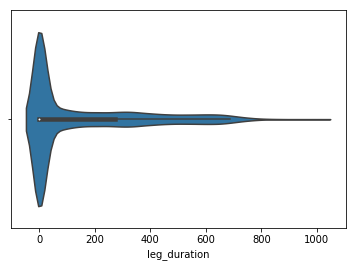

In [45]:
sns.violinplot(x=user_trips.toPandas()["leg_duration"])

In [46]:
user_trips.filter('leg_duration > 0').approxQuantile("leg_duration", [0.5], 0)

[281.0833333333333]

In [47]:
user_trips.write.csv(exp_data_folder_path + '/user_trips', header=True, mode='overwrite')

### Infer Destination Stops

In [48]:
user_trips_data = user_trips \
                .withColumn('o_date',F.from_unixtime(F.unix_timestamp(F.col('o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .withColumn('next_o_date',F.from_unixtime(F.unix_timestamp(F.col('next_o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .orderBy(['cardNum','o_date','o_timestamp'])

In [49]:
printdf(user_trips_data)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,628,HA251,2017-05-10,2,07:32:04,2055,6035109,-25.546812,-49.343321,35185,...,17:58:32,2899,6191373,-25.428445,-49.272962,29598,1443109011606,37924,75512,626.466667
1,901,MC302,2017-05-10,9,17:58:32,2899,6191373,-25.428445,-49.272962,29598,...,07:32:04,2055,6035109,-25.546812,-49.343321,35185,1434519076927,75512,37924,-1.000000
2,680,HA266,2017-05-10,2,07:03:52,3022,4525953,-25.582972,-49.328940,8239,...,17:47:17,2813,6221812,-25.420561,-49.268433,28882,1391569403940,36232,74837,643.416667
3,266,BN608,2017-05-10,14,17:47:17,2813,6221812,-25.420561,-49.268433,28882,...,07:03:52,3022,4525953,-25.582972,-49.328940,8239,403726925986,74837,36232,-1.000000
4,471,EC294,2017-05-10,1,06:00:06,1932,6355893,-25.489930,-49.225018,32158,...,07:28:44,2065,6487199,-25.519916,-49.278387,36109,1030792151228,32406,37724,88.633333
5,633,GA212,2017-05-10,4,07:28:44,2065,6487199,-25.519916,-49.278387,36109,...,06:00:06,1932,6355893,-25.489930,-49.225018,32158,1400159338612,37724,32406,-1.000000
6,870,BC598,2017-05-10,2,06:01:50,2247,5386363,-25.430770,-49.276242,29420,...,16:51:01,2115,6642380,-25.494003,-49.352445,35886,1322849927252,32510,71461,649.183333
7,658,JA026,2017-05-10,9,16:51:01,2115,6642380,-25.494003,-49.352445,35886,...,06:01:50,2247,5386363,-25.430770,-49.276242,29420,584115552383,71461,32510,-1.000000
8,779,JC864,2017-05-10,3,06:27:10,2904,5602243,-25.457090,-49.310536,33614,...,14:55:51,2953,3848606,-25.497289,-49.313547,36077,833223655624,34030,64551,508.683333
9,654,HA017,2017-05-10,13,14:55:51,2953,3848606,-25.497289,-49.313547,36077,...,06:27:10,2904,5602243,-25.457090,-49.310536,33614,154618822721,64551,34030,-1.000000


### Using BUSTE Data as a basis to infer trips destination locations

In [50]:
bus_trip_data = clean_buste_data.orderBy(['route','busCode','tripNum','timestamp']) \
                            .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                            .drop('cardNum') \
                            .withColumn('id',F.monotonically_increasing_id()) \
                            .withColumn('route', F.col('route').cast(T.IntegerType())) \
                            .withColumnRenamed('','cardNum')

In [51]:
user_trips_data.printSchema()

root
 |-- o_route: string (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: string (nullable = true)
 |-- o_tripNum: integer (nullable = true)
 |-- o_timestamp: string (nullable = true)
 |-- o_shape_id: integer (nullable = true)
 |-- o_shape_seq: integer (nullable = true)
 |-- o_shape_lat: double (nullable = true)
 |-- o_shape_lon: double (nullable = true)
 |-- o_stop_id: integer (nullable = true)
 |-- o_boarding_id: long (nullable = false)
 |-- cardNum: integer (nullable = true)
 |-- next_o_route: string (nullable = true)
 |-- next_o_bus_code: string (nullable = true)
 |-- next_o_date: string (nullable = true)
 |-- next_o_tripNum: integer (nullable = true)
 |-- next_o_timestamp: string (nullable = true)
 |-- next_o_shape_id: integer (nullable = true)
 |-- next_o_shape_seq: integer (nullable = true)
 |-- next_o_shape_lat: double (nullable = true)
 |-- next_o_shape_lon: double (nullable = true)
 |-- next_o_stop_id: integer (nullable = true)
 |-- next_o_boarding_id

In [52]:
bus_trip_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)
 |-- id: long (nullable = false)



In [53]:
cond = [bus_trip_data.route == user_trips_data.o_route, 
        bus_trip_data.busCode == user_trips_data.o_bus_code, 
        bus_trip_data.date == user_trips_data.o_date,
        bus_trip_data.tripNum == user_trips_data.o_tripNum]
od_trips = bus_trip_data.join(user_trips_data, cond, 'left_outer')

In [54]:
printdf(od_trips.orderBy(['route','busCode','tripNum','timestamp']))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,NaN,1,2934,6446501,-25.452183,-49.224040,0.000,DC852,None,-25.452220,...,None,None,None,None,None,None,None,None,None,None
1,NaN,1,2934,6447496,-25.450932,-49.219970,432.312,DC852,None,-25.450976,...,None,None,None,None,None,None,None,None,None,None
2,NaN,1,2934,6447510,-25.448710,-49.220020,739.771,DC852,None,-25.448616,...,None,None,None,None,None,None,None,None,None,None
3,NaN,1,2934,6447525,-25.446724,-49.221252,1001.839,DC852,None,-25.446655,...,None,None,None,None,None,None,None,None,None,None
4,NaN,1,2934,6447538,-25.444639,-49.223163,1393.901,DC852,None,-25.444756,...,None,None,None,None,None,None,None,None,None,None
5,NaN,1,2934,6447574,-25.440200,-49.221386,2247.402,DC852,None,-25.440206,...,None,None,None,None,None,None,None,None,None,None
6,1.0,1,2938,6451385,-25.428133,-49.264531,338.081,BN997,None,-25.428198,...,None,None,None,None,None,None,None,None,None,None
7,1.0,1,2938,6451394,-25.430622,-49.263426,635.815,BN997,None,-25.430830,...,None,None,None,None,None,None,None,None,None,None
8,1.0,1,2938,6451403,-25.433455,-49.262219,972.378,BN997,None,NaN,...,None,None,None,None,None,None,None,None,None,None
9,1.0,1,2938,6451415,-25.435452,-49.265462,1428.729,BN997,None,-25.435406,...,None,None,None,None,None,None,None,None,None,None


In [55]:
print od_trips.count()

3877508


In [56]:
trips_with_boardings = od_trips
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,23,3,3219,6479247,-25.430278,-49.211046,22831.418,BL324,None,-25.430296,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23,3,3219,6478761,-25.459446,-49.302470,3408.774,BL324,None,-25.459610,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,3,3219,6479293,-25.426009,-49.242224,26104.050,BL324,None,-25.425986,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23,3,3219,6479213,-25.439715,-49.221965,20657.293,BL324,None,-25.439630,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23,3,3219,6478907,-25.492337,-49.293746,8246.228,BL324,None,-25.492373,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,23,3,3219,6479263,-25.428790,-49.225490,24294.049,BL324,None,-25.428790,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,23,3,3219,6479091,-25.471793,-49.237555,16381.773,BL324,None,-25.471493,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,23,3,3219,6478843,-25.476399,-49.292988,5890.878,BL324,None,-25.476418,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,23,3,3219,6478987,-25.496312,-49.270431,11314.488,BL324,None,-25.496331,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,19,3077,4843548,-25.437491,-49.266078,4576.746,DN027,None,-25.437441,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
def dist(lat_x, long_x, lat_y, long_y):
    return F.acos(
        F.sin(F.toRadians(lat_x)) * F.sin(F.toRadians(lat_y)) + 
        F.cos(F.toRadians(lat_x)) * F.cos(F.toRadians(lat_y)) * 
            F.cos(F.toRadians(long_x) - F.toRadians(long_y))
    ) * F.lit(6371.0)

In [58]:
trips_with_boardings = trips_with_boardings.withColumn('dist',dist(F.col('shapeLat'),F.col('shapeLon'),F.col('next_o_shape_lat'),F.col('next_o_shape_lon')))

In [59]:
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration,dist
0,23,3,3219,6479247,-25.430278,-49.211046,22831.418,BL324,None,-25.430296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23,3,3219,6478761,-25.459446,-49.302470,3408.774,BL324,None,-25.459610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,3,3219,6479053,-25.481243,-49.247019,14786.299,BL324,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23,3,3219,6479293,-25.426009,-49.242224,26104.050,BL324,None,-25.425986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23,3,3219,6479213,-25.439715,-49.221965,20657.293,BL324,None,-25.439630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,23,3,3219,6479361,-25.410513,-49.248234,28715.133,BL324,None,-25.410488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,23,3,3219,6478907,-25.492337,-49.293746,8246.228,BL324,None,-25.492373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,23,3,3219,6479156,-25.452419,-49.229859,18702.365,BL324,None,-25.452296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,23,3,3219,6479263,-25.428790,-49.225490,24294.049,BL324,None,-25.428790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,23,3,3219,6479091,-25.471793,-49.237555,16381.773,BL324,None,-25.471493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
w = Window().partitionBy(['cardNum','date','route','busCode','tripNum']).orderBy('dist')

od_matrix = trips_with_boardings.filter('timestamp > o_timestamp') \
                    .withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

In [61]:
printdf(od_matrix.select(['cardNum','route','tripNum','o_stop_id','o_timestamp','stopPointId','timestamp','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,route,tripNum,o_stop_id,o_timestamp,stopPointId,timestamp,dist
0,304127,628,2,35185,07:32:04,35187,07:32:49,14.796845
1,306573,680,2,8239,07:03:52,31034,07:46:43,11.311857
2,306573,266,14,28882,17:47:17,30774,17:49:54,4.812502
3,313992,471,1,32158,06:00:06,29701,06:49:40,2.418512
4,313992,633,4,36109,07:28:44,31021,07:45:17,9.909206
5,317896,870,2,29420,06:01:50,35079,23:54:40,11.587890
6,317896,658,9,35886,16:51:01,27620,17:19:57,3.161976
7,321530,779,3,33614,06:27:10,9385,06:36:28,9.610683
8,321530,654,13,36077,14:55:51,27485,15:05:48,8.400315
9,321916,472,6,29702,08:06:15,26583,08:32:46,5.507953


In [62]:
printdf(od_matrix.select(['cardNum','o_stop_id','o_timestamp','stopPointId','timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,o_stop_id,o_timestamp,stopPointId,timestamp,shapeLat,shapeLon,next_o_shape_lat,next_o_shape_lon,dist
0,304127,35185,07:32:04,35187,07:32:49,-25.543671,-49.343730,-25.430931,-49.265415,14.796845
1,306573,8239,07:03:52,31034,07:46:43,-25.512861,-49.294952,-25.450101,-49.206261,11.311857
2,306573,28882,17:47:17,30774,17:49:54,-25.417213,-49.265781,-25.458418,-49.251119,4.812502
3,313992,32158,06:00:06,29701,06:49:40,-25.467371,-49.240997,-25.452114,-49.223827,2.418512
4,313992,36109,07:28:44,31021,07:45:17,-25.512341,-49.294789,-25.427901,-49.263238,9.909206
5,317896,29420,06:01:50,35079,23:54:40,-25.438473,-49.310486,-25.541681,-49.294497,11.587890
6,317896,35886,16:51:01,27620,17:19:57,-25.492096,-49.293124,-25.466362,-49.279723,3.161976
7,321530,33614,06:27:10,9385,06:36:28,-25.459064,-49.302164,-25.516804,-49.230914,9.610683
8,321530,36077,14:55:51,27485,15:05:48,-25.492007,-49.293329,-25.447553,-49.225671,8.400315
9,321916,29702,08:06:15,26583,08:32:46,-25.439424,-49.269795,-25.459817,-49.319788,5.507953


In [63]:
printdf(od_matrix.describe('dist'))

,summary,dist
0,count,54230
1,mean,6.71390882852522
2,stddev,4.4788440291974965
3,min,0.0
4,max,30.172753958356612


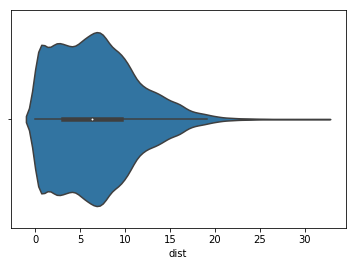

In [64]:
sns.violinplot(x=od_matrix.toPandas()["dist"])

In [65]:
inference_ok = 100*(od_matrix.filter('dist <= 1.0').count()/float(od_matrix.count()))
print "Percentage of trips with destionation satisfying threshold: ", inference_ok, "%"

Percentage of trips with destionation satisfying threshold:  9.47814862622 %


In [66]:
print od_matrix.count()

54230


In [67]:
filtered_od_matrix = od_matrix.filter('dist <= 1.0')

In [68]:
print filtered_od_matrix.count()

5140


### Enriching BUSTE output with bus crowdedness information

In [69]:
trips_origins = filtered_od_matrix.filter(filtered_od_matrix.cardNum.isNotNull()) \
                            .select(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id','o_timestamp']) \
                            .groupBy(['o_date','o_route','o_bus_code','o_tripNum','o_stop_id']) \
                            .count() \
                            .withColumnRenamed('count','boarding_cnt') \
                            .orderBy(['o_date','o_route','o_bus_code','o_tripNum'])

In [70]:
printdf(trips_origins, l=20)

,o_date,o_route,o_bus_code,o_tripNum,o_stop_id,boarding_cnt
0,2017-05-10,001,BN997,4,35219,1
1,2017-05-10,001,BN997,19,31453,1
2,2017-05-10,001,BN997,22,26166,1
3,2017-05-10,002,DN027,9,28604,1
4,2017-05-10,002,DN027,13,47784,1
5,2017-05-10,002,DN027,13,28603,1
6,2017-05-10,002,DN027,17,40026,1
7,2017-05-10,002,DN028,3,31456,1
8,2017-05-10,002,DN028,4,26552,1
9,2017-05-10,002,DN028,9,28603,1


In [71]:
trips_destinations = filtered_od_matrix.filter(filtered_od_matrix.cardNum.isNotNull()) \
                            .select(['date','route','busCode','tripNum','stopPointId','timestamp']) \
                            .groupBy(['date','route','busCode','tripNum','stopPointId']) \
                            .count() \
                            .orderBy(['date','route','busCode','tripNum'])

In [72]:
trips_destinations = rename_columns(
                        trips_destinations,
                        [('date','d_date'),
                         ('route','d_route'),
                         ('busCode','d_bus_code'),
                         ('tripNum','d_tripNum'),
                         ('stopPointId','d_stop_id'),
                         ('count','alighting_cnt')])

In [73]:
printdf(trips_destinations, l=20)

,d_date,d_route,d_bus_code,d_tripNum,d_stop_id,alighting_cnt
0,2017-05-10,1,BN997,4,26375,1
1,2017-05-10,1,BN997,19,29082,1
2,2017-05-10,1,BN997,22,35219,1
3,2017-05-10,2,DN027,9,31458,1
4,2017-05-10,2,DN027,13,31458,1
5,2017-05-10,2,DN027,13,40031,1
6,2017-05-10,2,DN027,17,31458,1
7,2017-05-10,2,DN028,3,29917,1
8,2017-05-10,2,DN028,4,40031,1
9,2017-05-10,2,DN028,9,28579,2


In [74]:
origin_cond = [bus_trip_data.date == trips_origins.o_date,
               bus_trip_data.route == trips_origins.o_route, 
               bus_trip_data.busCode == trips_origins.o_bus_code, 
               bus_trip_data.tripNum == trips_origins.o_tripNum,
               bus_trip_data.stopPointId == trips_origins.o_stop_id
]

dest_cond = [bus_trip_data.date == trips_destinations.d_date,
               bus_trip_data.route == trips_destinations.d_route, 
               bus_trip_data.busCode == trips_destinations.d_bus_code, 
               bus_trip_data.tripNum == trips_destinations.d_tripNum,
               bus_trip_data.stopPointId == trips_destinations.d_stop_id
]


buste_crowdedness = bus_trip_data.join(trips_origins,origin_cond,'left_outer') \
                        .join(trips_destinations,dest_cond,'left_outer') \
                        .drop('o_date','o_route','o_bus_code','o_tripNum','o_stop_id') \
                        .drop('d_date','d_route','d_bus_code','d_tripNum','d_stop_id') \
                        .withColumn('boarding_cnt',F.when(F.col('boarding_cnt').isNull(),F.lit(0)).otherwise(F.col('boarding_cnt'))) \
                        .withColumn('alighting_cnt',F.when(F.col('alighting_cnt').isNull(),F.lit(0)).otherwise(F.col('alighting_cnt'))) \

In [75]:
printdf(buste_crowdedness.filter(buste_crowdedness.boarding_cnt > 0))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,stopPointId,problem,birthdate,cardTimestamp,lineName,gender,date,id,boarding_cnt,alighting_cnt
0,21,2,3263,5215517,-25.422412,-49.292449,10019.879,BB601,None,-25.422550,...,33068,NO_PROBLEM,02/01/94,08:54:57,INTERB II ANTI H,M,2017-05-10,386547056701,1,1
1,50,3,1720,5304877,-25.464645,-49.277819,11696.420,LA054,None,-25.464640,...,29163,NO_PROBLEM,16/09/65,12:39:32,INTERBAIRROS V,F,2017-05-10,764504178947,1,0
2,169,3,2720,5197961,-25.391356,-49.294594,7092.232,BC002,None,-25.391316,...,775,NO_PROBLEM,16/02/97,06:21:54,JD. KOSMOS,M,2017-05-10,1262720385338,1,0
3,176,4,1745,5254946,-25.378287,-49.280773,385.024,BC939,None,-25.378363,...,28558,NO_PROBLEM,13/02/81,08:34:55,NILO PEÇANHA,F,2017-05-10,154618822978,1,0
4,180,8,2758,5996239,-25.415837,-49.271438,4536.186,HA311,None,-25.415883,...,28594,NO_PROBLEM,12/07/58,17:58:23,AVERDE/ABRANCHES,M,2017-05-10,360777253180,1,0
5,182,10,2629,6095265,-25.427761,-49.270979,10625.315,BC302,None,NaN,...,28946,BETWEEN,14/06/82,14:27:32,ABRANCHES,F,2017-05-10,1082331758995,1,0
6,183,7,1753,6096529,-25.427743,-49.270965,10201.640,BC500,None,-25.427743,...,28946,NO_PROBLEM,12/01/87,13:32:12,JD. CHAPARRAL,F,2017-05-10,369367187875,1,0
7,280,1,1836,6241730,-25.373673,-49.235305,569.441,BN629,None,NaN,...,35597,BETWEEN,03/02/71,06:33:01,N. SRA.DE NAZARÉ,M,2017-05-10,575525618431,3,0
8,341,1,1873,6490805,-25.403401,-49.196360,2294.651,BA030,None,-25.403466,...,35247,NO_PROBLEM,06/01/52,05:17:14,B.ALTO/STA.CA,M,2017-05-10,1632087573402,1,0
9,365,7,2816,6244745,-25.424402,-49.259234,4156.936,BC946,None,-25.424518,...,29898,NO_PROBLEM,05/10/82,16:26:16,JD.SOCIAL/BATEL,F,2017-05-10,841813590990,1,0


In [76]:
trips_window = Window.partitionBy(['date','route','busCode','tripNum']).orderBy('timestamp')

buste_crowdedness = buste_crowdedness.withColumn('crowd_bal', F.col('boarding_cnt') - F.col('alighting_cnt')) \
                        .withColumn('num_pass',F.sum('crowd_bal').over(trips_window)) \
                        .drop('numPassengers','gps_timestamp','gps_timestamp_in_secs') \
                        .orderBy(['date','route','busCode','tripNum','timestamp'])                        

In [77]:
printdf(buste_crowdedness.select(['date','route','busCode','tripNum','stopPointId','timestamp','boarding_cnt','alighting_cnt','crowd_bal','num_pass']) \
                           .orderBy(['date','route','busCode','tripNum','timestamp'])
       ,l=100)

,date,route,busCode,tripNum,stopPointId,timestamp,boarding_cnt,alighting_cnt,crowd_bal,num_pass
0,2017-05-10,NaN,DC852,1,14404,07:39:06,0,0,0,0
1,2017-05-10,NaN,DC852,1,32415,07:40:11,0,0,0,0
2,2017-05-10,NaN,DC852,1,32413,07:40:58,0,0,0,0
3,2017-05-10,NaN,DC852,1,32412,07:41:54,0,0,0,0
4,2017-05-10,NaN,DC852,1,33024,07:42:55,0,0,0,0
5,2017-05-10,NaN,DC852,1,27959,07:46:37,0,0,0,0
6,2017-05-10,1.0,BN997,1,29887,06:21:08,0,0,0,0
7,2017-05-10,1.0,BN997,1,31453,06:22:10,0,0,0,0
8,2017-05-10,1.0,BN997,1,31454,06:22:44,0,0,0,0
9,2017-05-10,1.0,BN997,1,30748,06:24:42,0,0,0,0


### Extrapolating results to all trips based on per-route proportion

In [87]:
boarding_data_route_boarding = bus_trip_data.groupby(['route']).count() \
                                .withColumnRenamed('count','overall_boarding')
printdf(boarding_data_route_boarding)

,route,overall_boarding
0,463,2236
1,471,2573
2,243,1052
3,540,182
4,623,3188
5,472,2796
6,322,539
7,513,2908
8,918,986
9,321,22


In [88]:
od_matrix_route_boarding = filtered_od_matrix.groupby(['route']).count() \
                            .withColumnRenamed('count','odmatrix_boarding')
printdf(od_matrix_route_boarding)

,route,odmatrix_boarding
0,463,57
1,471,41
2,623,8
3,243,3
4,472,64
5,322,1
6,513,3
7,673,16
8,633,7
9,375,22


In [94]:
od_matrix_route_prop = boarding_data_route_boarding.join(od_matrix_route_boarding, 'route','left_outer') \
                        .withColumn('extrap_factor',F.when(((F.col('odmatrix_boarding') == 0) | (F.col('odmatrix_boarding').isNull())), 0.0) \
                                    .otherwise(F.col('overall_boarding').cast('float')/F.col('odmatrix_boarding')))

In [95]:
printdf(od_matrix_route_prop,l=30)

,route,overall_boarding,odmatrix_boarding,extrap_factor
0,463,2236,57.0,39.228070
1,471,2573,41.0,62.756098
2,243,1052,3.0,350.666667
3,540,182,NaN,0.000000
4,623,3188,8.0,398.500000
5,472,2796,64.0,43.687500
6,322,539,1.0,539.000000
7,513,2908,3.0,969.333333
8,918,986,NaN,0.000000
9,321,22,NaN,0.000000


In [98]:
buste_crowdedness_extrapolated = buste_crowdedness.join(od_matrix_route_prop, 'route', 'left') \
                                .drop('overall_boarding','odmatrix_boarding') \
                                .withColumn('ext_num_pass', F.col('num_pass')*F.col('extrap_factor'))

In [ ]:
printdf(buste_crowdedness_extrapolated.select(['date','route','busCode','tripNum','stopPointId','timestamp','boarding_cnt','alighting_cnt','crowd_bal','num_pass','extrap_factor','ext_num_pass']) \
                           .orderBy(['date','route','busCode','tripNum','timestamp']) \
                            .filter('num_pass' > 0)
       ,l=100)

In [ ]:
buste_crowdedness_extrapolated.write.csv(path=exp_data_folder_path+'/buste_crowdedness',header=True, mode='overwrite')